<a href="https://colab.research.google.com/github/rcbusinesstechlab/realtime-face-recognition/blob/main/ok_Multiple_in_single_graph_Comparison_SE_and_KAN_SE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

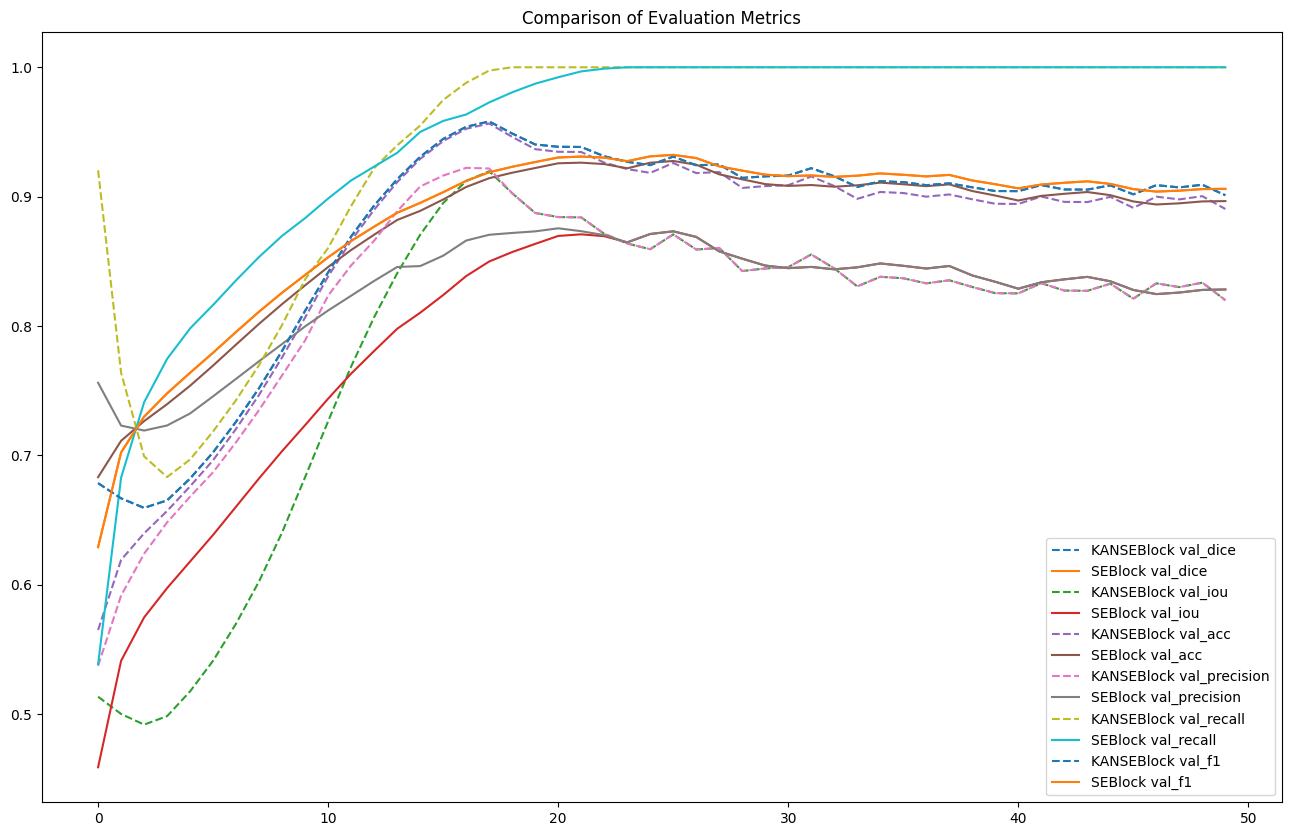

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# ─── Dice & IoU Calculation ───────────────────────────────────
def dice_coefficient(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2.*intersection + epsilon) / (union + epsilon)
    return dice.mean().item()

def iou_score(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(2,3))
    union = (pred + target - pred*target).sum(dim=(2,3))
    iou = (intersection + epsilon) / (union + epsilon)
    return iou.mean().item()

# ─── Accuracy, Precision, Recall, F1 Score ────────────────────
def compute_metrics(pred, target):
    pred = (pred > 0.5).view(-1).cpu().numpy()
    target = (target > 0.5).view(-1).cpu().numpy()

    accuracy = accuracy_score(target, pred)
    precision, recall, f1, _ = precision_recall_fscore_support(target, pred, average='binary', zero_division=0)

    return accuracy, precision, recall, f1

# ─── Standard SE Block ───────────────────────────────────────
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        mid_channels = max(1, in_channels // reduction)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, mid_channels)
        self.fc2 = nn.Linear(mid_channels, in_channels)
        self.activation = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B, C, H, W = x.shape
        z = self.global_pool(x).view(B, C)
        h = self.activation(self.fc1(z))
        s = self.sigmoid(self.fc2(h)).view(B, C, 1, 1)
        return x * s

# ─── KANSEBlock ──────────────────────────────────────────────
class KANSEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        mid_channels = max(1, in_channels // reduction)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, mid_channels)
        self.fc2 = nn.Linear(mid_channels, in_channels)
        self.activation = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B, C, H, W = x.shape
        z = self.global_pool(x).view(B, C)
        h = self.activation(self.fc1(z))
        s = self.sigmoid(self.fc2(h)).view(B, C, 1, 1)
        return x * s

# ─── UNet Block with Option for KAN or SE ────────────────────
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_kan=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            KANSEBlock(out_channels) if use_kan else SEBlock(out_channels)
        )

    def forward(self, x):
        return self.conv(x)

# ─── Training & Evaluation Function ───────────────────────────
def train_validate_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50, device='cpu'):
    history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': [],
               'train_iou': [], 'val_iou': [], 'train_acc': [], 'val_acc': [],
               'train_precision': [], 'val_precision': [], 'train_recall': [], 'val_recall': [],
               'train_f1': [], 'val_f1': []}

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_losses, train_dices, train_ious, train_accs, train_precisions, train_recalls, train_f1s = [], [], [], [], [], [], []

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            probs = torch.sigmoid(outputs)

            train_losses.append(loss.item())
            train_dices.append(dice_coefficient(probs, masks))
            train_ious.append(iou_score(probs, masks))
            acc, p, r, f1 = compute_metrics(probs, masks)
            train_accs.append(acc)
            train_precisions.append(p)
            train_recalls.append(r)
            train_f1s.append(f1)

        model.eval()
        val_losses, val_dices, val_ious, val_accs, val_precisions, val_recalls, val_f1s = [], [], [], [], [], [], []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                probs = torch.sigmoid(outputs)

                val_losses.append(loss.item())
                val_dices.append(dice_coefficient(probs, masks))
                val_ious.append(iou_score(probs, masks))
                acc, p, r, f1 = compute_metrics(probs, masks)
                val_accs.append(acc)
                val_precisions.append(p)
                val_recalls.append(r)
                val_f1s.append(f1)

        # Store metrics
        for key, values in zip(history.keys(), [train_losses, val_losses, train_dices, val_dices,
                                                train_ious, val_ious, train_accs, val_accs,
                                                train_precisions, val_precisions, train_recalls, val_recalls,
                                                train_f1s, val_f1s]):
            history[key].append(np.mean(values))

    return model, history

# ─── Compare Models & Visualize ───────────────────────────────
def compare_models():
    images = torch.rand(100,1,64,64)
    masks = (images > 0.5).float()

    dataset = TensorDataset(images, masks)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=8)

    criterion = nn.BCEWithLogitsLoss()

    model_kan = UNetBlock(1, 1, use_kan=True)
    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=1e-3)
    model_kan, history_kan = train_validate_model(model_kan, train_loader, val_loader, optimizer_kan, criterion)

    model_se = UNetBlock(1, 1, use_kan=False)
    optimizer_se = torch.optim.Adam(model_se.parameters(), lr=1e-3)
    model_se, history_se = train_validate_model(model_se, train_loader, val_loader, optimizer_se, criterion)

    # Plot Evaluation Metrics Comparison
    plt.figure(figsize=(16,10))
    for metric in ['val_dice', 'val_iou', 'val_acc', 'val_precision', 'val_recall', 'val_f1']:
        plt.plot(history_kan[metric], label=f'KANSEBlock {metric}', linestyle='dashed')
        plt.plot(history_se[metric], label=f'SEBlock {metric}', linestyle='solid')
    plt.legend()
    plt.title("Comparison of Evaluation Metrics")
    plt.show()

compare_models()
